In [1]:
import pandas as pd

# = = = = = = = = = = = = = = =

import requests

import sys
sys.path.append('../00.Tools')
from crawler_configuration_oversea import get_header, get_proxy

from bs4 import BeautifulSoup
from lxml import etree

# = = = = = = = = = = = = = = =

import re
import html as html_lib

import json

In [2]:
list_dict_correct, list_series_error, df_input = [], [], pd.read_excel('./file/3.model.xlsx',
                                                                       header=0,
                                                                       dtype=str).fillna('')

df_input['Year'] = df_input['Year'].astype(int)
df_input['Make No'] = df_input['Make No'].astype(int)
df_input['Model No'] = df_input['Model No'].astype(int)

count_remain = len(df_input)

print(f'总数量：{count_remain}')
print()
df_input

总数量：17458



,Year,Make No,Make,Model No,Model
0,2025,1,Cadillac,1,CT5
1,2025,2,INFINITI,1,QX80
2,2025,3,Toyota,1,Camry
3,2024,1,Acura,1,Integra
4,2024,1,Acura,2,RDX
...,...,...,...,...,...
17453,1958,2,Plymouth,2,Fury
17454,1958,2,Plymouth,3,Savoy
17455,1957,1,Plymouth,1,Belvedere
17456,1957,1,Plymouth,2,Fury


In [3]:
crawler_status, (crawler_index, crawler_series) = False, next(df_input.iterrows())

crawler_status, crawler_index, crawler_series

(False,
 0,
 Year            2025
 Make No            1
 Make        Cadillac
 Model No           1
 Model            CT5
 Name: 0, dtype: object)

1
2
3
4
5
<!DOCTYPE html>
<html class="no-js" dir="ltr" lang="en-US" prefix="og: https://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <link href="/apple-touch-icon.png?v=5" rel="apple-touch-icon" sizes="180x180"/>
  <link href="/favicon-32x32.png?v=5" rel="icon" sizes="32x32" type="image/png"/>
  <link href="/favicon-16x16.png?v=5" rel="icon" sizes="16x16" type="image/png"/>
  <link href="/site.webmanifest?v=5" rel="manifest"/>
  <link color="#5bbad5" href="/safari-pinned-tab.svg?v=5" rel="mask-icon"/>
  <link href="/favicon.ico?v=5" rel="shortcut icon"/>
  <meta content="#da532c" name="msapplication-TileColor"/>
  <meta content="/mstile-144x144.png?v=5" name="msapplication-TileImage"/>
  <meta content="#ffffff" name="theme-color"/>
  <title>
   Blade Size Finder - Rain-X
  </title>
  <style>
   #wpadminbar #wp-admin-bar-p404_free_top_button .ab-icon:before {
            content: "\f103";
            color:red;
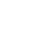
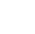
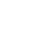
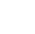

In [4]:
import time

data = {'search_url': 'https://www.rainx.com/',
        'bf-year': crawler_series['Year'],
        'bf-make': crawler_series['Make'],
        'bf-model': crawler_series['Model']}

count_retry = 0
while True:
    count_retry += 1
    print(count_retry)
    try:
        url_check = 'https://www.rainx.com/'

        resp = requests.post('https://www.rainx.com/blade-size-finder/',
                             data=data,
                             headers=get_header(),
                             proxies=get_proxy(),
                             timeout=(10, 60))

        if resp.status_code == 200:
            soup = BeautifulSoup(resp.text, 'lxml')
            html = etree.HTML(str(soup))

            if html.xpath('//div[@class="your_vechicle clearfix"]/label/strong/text()') and html.xpath('//div[@class="your_vechicle clearfix"]/label/strong/text()')[0] == f'''{crawler_series['Year']} {crawler_series['Make']} {crawler_series['Model']}''' or html.xpath('//div[@class="no-result"]/h2/text()') and html.xpath('//div[@class="no-result"]/h2/text()')[0] == 'We\'re Sorry...':
                break
    except KeyboardInterrupt:
        break
    except:
        time.sleep(3)
        continue

print(soup.prettify())

In [5]:
html.xpath('//div[@class="no-result"]/h2/text()') and html.xpath('//div[@class="no-result"]/h2/text()')[0] == 'We\'re Sorry...'

[]

In [6]:
list_dict_correct_temp, list_div = [], html.xpath('//div[@class="blade-size-finder-container"]/div[@class="col-3"]')
for i, div in enumerate(list_div):
    category, category_description = div.xpath('./header/a/h3/text()')[0].strip(), div.xpath('./header/a/span[@class="h6"]/text()')[0].strip()

    list_li = div.xpath('./ul/li')
    for j, li in enumerate(list_li):
        status = li.xpath('./@class')[0].strip()

        url = li.xpath('./a/@href')[0].strip()

        dict_src, list_src = {}, li.xpath('./a/figure/img/@src')
        for k, src in enumerate(list_src):
            dict_src[str(k)] = src.strip()

        span = li.xpath('./a/span[@class="h6 wiper_blade_heading"]')[0]
        title = etree.tostring(span).decode('utf-8')
        title = re.sub(r'<.*?>', '', title)
        title = re.sub(r' +', ' ', title.strip())
        title = html_lib.unescape(title)

        dict_correct_temp = {'Year': crawler_series['Year'],
                             'Make No': crawler_series['Make No'],
                             'Make': crawler_series['Make'],
                             'Model No': crawler_series['Model No'],
                             'Model': crawler_series['Model'],
                             'Category No': i + 1,
                             'Category': category,
                             'Category Description': category_description,
                             'Part No': j + 1,
                             'Status': status,
                             'Title': title,
                             'Picture': '',
                             'Url': url,
                             'Json_Src': json.dumps(dict_src)}

        list_head, list_row = li.xpath('./div[@class="product_blade_size clearfix"]/ul[@class="product_size_labels"]/li[1]/strong/text()'), li.xpath('./div[@class="product_blade_size clearfix"]/ul[@class="product_size_labels"]/li')[1:]
        for k, row in enumerate(list_row):
            for m, head in enumerate(list_head):
                if k == 0:
                    dict_correct_temp[head] = row.xpath(f'./span[{m+1}]/text()')[0].strip()
                else:
                    dict_correct_temp[f'{head}_{k+1}'] = row.xpath(f'./span[{m+1}]/text()')[0].strip()

        list_dict_correct_temp.append(dict_correct_temp)

list_dict_correct_temp

[{'Year': 2025,
  'Make No': 1,
  'Make': 'Cadillac',
  'Model No': 1,
  'Model': 'CT5',
  'Category No': 1,
  'Category': 'ULTIMATE',
  'Category Description': 'Premium Beam Blade',
  'Part No': 1,
  'Status': '',
  'Title': 'Rain-X® Truck & SUV Wiper Blade – Style 2',
  'Picture': '',
  'Url': 'https://www.rainx.com/product/truck-suv-bronze-package/?bf-year=2025&bf-make=Cadillac&bf-model=CT5#find-your-blade',
  'Json_Src': '{"0": "https://www.rainx.com/wp-content/uploads/2023/08/RL-Truck-SUV-V2-POY.png", "1": "https://www.rainx.com/wp-content/uploads/2023/08/Truck-SUV-V2-POY-208x400.png"}',
  'Position': 'Passenger',
  'Length/Model Code': '18"',
  'Arm Type': '9 X 3 Hook',
  'US Part #': '870218'},
 {'Year': 2025,
  'Make No': 1,
  'Make': 'Cadillac',
  'Model No': 1,
  'Model': 'CT5',
  'Category No': 1,
  'Category': 'ULTIMATE',
  'Category Description': 'Premium Beam Blade',
  'Part No': 2,
  'Status': '',
  'Title': 'Rain-X® Rugged XL™ Wiper Blade',
  'Picture': '',
  'Url': 'ht

In [7]:
list_dict_correct.extend(list_dict_correct_temp)

list_dict_correct

[{'Year': 2025,
  'Make No': 1,
  'Make': 'Cadillac',
  'Model No': 1,
  'Model': 'CT5',
  'Category No': 1,
  'Category': 'ULTIMATE',
  'Category Description': 'Premium Beam Blade',
  'Part No': 1,
  'Status': '',
  'Title': 'Rain-X® Truck & SUV Wiper Blade – Style 2',
  'Picture': '',
  'Url': 'https://www.rainx.com/product/truck-suv-bronze-package/?bf-year=2025&bf-make=Cadillac&bf-model=CT5#find-your-blade',
  'Json_Src': '{"0": "https://www.rainx.com/wp-content/uploads/2023/08/RL-Truck-SUV-V2-POY.png", "1": "https://www.rainx.com/wp-content/uploads/2023/08/Truck-SUV-V2-POY-208x400.png"}',
  'Position': 'Passenger',
  'Length/Model Code': '18"',
  'Arm Type': '9 X 3 Hook',
  'US Part #': '870218'},
 {'Year': 2025,
  'Make No': 1,
  'Make': 'Cadillac',
  'Model No': 1,
  'Model': 'CT5',
  'Category No': 1,
  'Category': 'ULTIMATE',
  'Category Description': 'Premium Beam Blade',
  'Part No': 2,
  'Status': '',
  'Title': 'Rain-X® Rugged XL™ Wiper Blade',
  'Picture': '',
  'Url': 'ht

In [8]:
crawler_status = True

crawler_status

True

In [9]:
crawler_series['Check_Url'] = url_check

list_series_error.append(crawler_series)

list_series_error

[Year                           2025
 Make No                           1
 Make                       Cadillac
 Model No                          1
 Model                           CT5
 Check_Url    https://www.rainx.com/
 Name: 0, dtype: object]

In [10]:
if list_dict_correct:
    df_correct = pd.DataFrame(list_dict_correct).sort_values(by=['Year', 'Make No', 'Model No', 'Category No', 'Part No'],
                                                             ascending=[False, True, True, True, True],
                                                             ignore_index=True)
    df_correct.to_excel('./test_part.xlsx', index=False)

df_correct

,Year,Make No,Make,Model No,Model,Category No,Category,Category Description,Part No,Status,Title,Picture,Url,Json_Src,Position,Length/Model Code,Arm Type,US Part #
0,2025,1,Cadillac,1,CT5,1,ULTIMATE,Premium Beam Blade,1,,Rain-X® Truck & SUV Wiper Blade – Style 2,,https://www.rainx.com/product/truck-suv-bronze...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,870218
1,2025,1,Cadillac,1,CT5,1,ULTIMATE,Premium Beam Blade,2,,Rain-X® Rugged XL™ Wiper Blade,,https://www.rainx.com/product/rugged-xl/?bf-ye...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,870118
2,2025,1,Cadillac,1,CT5,1,ULTIMATE,Premium Beam Blade,3,,Rain-X® Truck & SUV Wiper Blade,,https://www.rainx.com/product/rain-x-truck-suv...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,870118
3,2025,1,Cadillac,1,CT5,1,ULTIMATE,Premium Beam Blade,4,,Rain-X® Silicone AdvantEdge® Wiper Blades,,https://www.rainx.com/product/silicone-advante...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,830018
4,2025,1,Cadillac,1,CT5,1,ULTIMATE,Premium Beam Blade,5,,Rain-X® Acoustix™ Wiper Blade,,https://www.rainx.com/product/rain-x-acoustix-...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,870518
5,2025,1,Cadillac,1,CT5,1,ULTIMATE,Premium Beam Blade,6,,Rain-X® Silicone Endura® Wiper Blades,,https://www.rainx.com/product/silicone-endura/...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,830118
6,2025,1,Cadillac,1,CT5,1,ULTIMATE,Premium Beam Blade,7,,Rain-X® Silicone Supreme® Wiper Blades,,https://www.rainx.com/product/rain-x-silicone-...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,830518
7,2025,1,Cadillac,1,CT5,1,ULTIMATE,Premium Beam Blade,8,,Rain-X® Quantum® Elite Wiper Blades,,https://www.rainx.com/product/rain-x-quantum-e...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,870032-2
8,2025,1,Cadillac,1,CT5,1,ULTIMATE,Premium Beam Blade,9,,Rain‑X® Latitude® Water Repellency 2-n-1 Wiper...,,https://www.rainx.com/product/rain-x-latitude-...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,5079275-2
9,2025,1,Cadillac,1,CT5,2,BEST,Beam Blade,1,,Rain-X® Longitude™ Professional Series Wiper B...,,https://www.rainx.com/product/rain-x-longitude...,"{""0"": ""https://www.rainx.com/wp-content/upload...",Passenger,"18""",9 X 3 Hook,830318


In [11]:
if list_series_error:
    df_error = pd.DataFrame(list_series_error).sort_values(by=['Year', 'Make No', 'Model No'],
                                                           ascending=[False, True, True],
                                                           ignore_index=True)
    df_error.to_excel('./test_part_error.xlsx', index=False)

df_error

,Year,Make No,Make,Model No,Model,Check_Url
0,2025,1,Cadillac,1,CT5,https://www.rainx.com/
